### 적대적 생성 신경망 (GAN)

In [1]:
# 랜덤 시드 설정
import numpy as np
import tensorflow as tf
np.random.seed(0)
tf.random.set_seed(0)

In [2]:
# 데이터 불러오기
from tensorflow.keras.datasets import mnist
(X_raw, _), (_, _) = mnist.load_data()

In [3]:
# 변수 설정
n_img = X_raw.shape[0]
epoch = 3000
n_batch = 100

In [4]:
# 데이터 전처리
import numpy as np
X_re = X_raw.reshape(n_img, 28, 28, 1)
scale_c = 255/2
X = (X_re - scale_c) / scale_c
real_1 = np.ones((n_batch, 1))  # 실제 손글씨 데이터이므로 모두 1을 가짐
fake_0 = np.zeros((n_batch, 1)) # 가짜 손글씨 데이터이므로 모두 0을 가짐

In [5]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import LeakyReLU

In [6]:
# 생성자 (Generator)
input_layer1 = Input(shape=(100,))
x1 = Dense(64*7*7)(input_layer1)
x1 = BatchNormalization()(x1)
x1 = Activation(LeakyReLU(0.3))(x1)
x1 = Reshape((7,7,64))(x1)
x1 = UpSampling2D()(x1)
x1 = Conv2D(32, kernel_size=(3,3), padding='same')(x1)
x1 = BatchNormalization()(x1)
x1 = Activation(LeakyReLU(0.3))(x1)
x1 = UpSampling2D()(x1)
output_layer1 = Conv2D(1, kernel_size=(3,3),
                       padding='same',
                       activation='tanh')(x1)
generator = Model(input_layer1, output_layer1)
generator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense (Dense)                (None, 3136)              316736    
_________________________________________________________________
batch_normalization (BatchNo (None, 3136)              12544     
_________________________________________________________________
activation (Activation)      (None, 3136)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 32)        18464 

In [7]:
# 판별자 (Discriminator)
input_layer2 = Input(shape=(28, 28, 1))
x2 = Conv2D(64, kernel_size=(5,5), padding='same')(input_layer2)
x2 = Activation(LeakyReLU(0.3))(x2)
x2 = Dropout(0.25)(x2)
x2 = Conv2D(128, kernel_size=(3,3), padding='same')(x2)
x2 = Activation(LeakyReLU(0.3))(x2)
x2 = Dropout(0.25)(x2)
x2 = Flatten()(x2)
output_layer2 = Dense(1, activation='sigmoid')(x2)
discriminator = Model(input_layer2, output_layer2)
discriminator.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
discriminator.trainable = False
discriminator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        1664      
_________________________________________________________________
activation_2 (Activation)    (None, 28, 28, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
activation_3 (Activation)    (None, 28, 28, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 128)       0   

In [8]:
# GAN 모형 생성
input_gan = Input(shape=(100,))
output_dis = discriminator(generator(input_gan))
gan = Model(input_gan, output_dis)
gan.compile(loss='binary_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])
gan.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
model (Model)                (None, 28, 28, 1)         348161    
_________________________________________________________________
model_1 (Model)              (None, 1)                 175873    
Total params: 524,034
Trainable params: 341,825
Non-trainable params: 182,209
_________________________________________________________________


In [9]:
# 학습
import numpy as np
loss_disc_real = [0]*epoch
loss_disc_fake = [0]*epoch
loss_disc_avg = [0]*epoch
loss_gan = [0]*epoch
acc_disc_real = [0]*epoch
acc_disc_fake = [0]*epoch
acc_disc_avg = [0]*epoch
acc_gan = [0]*epoch

for i in range(0, epoch):
    # 실제 데이터 판별
    idx = np.random.randint(0, n_img, n_batch)
    imgs = X[idx]
    res_real = discriminator.train_on_batch(imgs, real_1)

    # 가짜 데이터 생성 및 판별
    fake = np.random.normal(0, 1, size=(n_batch, 100))
    gen_imgs = generator.predict(fake)
    res_fake = discriminator.train_on_batch(gen_imgs, fake_0)

    # 판별 손실 평균 & 정확도 평균
    loss_disc_avg_ith = np.add(res_real[0],res_fake[0])*0.5
    acc_disc_avg_ith = np.add(res_real[1],res_fake[1])*0.5

    # GAN 결과
    res_gan = gan.train_on_batch(fake, real_1)

    # 정확도 및 손실
    loss_disc_real[i] = res_real[0]
    loss_disc_fake[i] = res_fake[0]
    loss_disc_avg[i] = loss_disc_avg_ith
    loss_gan[i] = res_gan[0]

    acc_disc_real[i] = res_real[1]
    acc_disc_fake[i] = res_fake[1]
    acc_disc_avg[i] = acc_disc_avg_ith
    acc_gan[i] = res_gan[1]

    if i %10==9:
        print('epoch:%d'%i,
          ' 판별손실평균:%.4f'%loss_disc_avg_ith,
          ' 판별정확도평균:%.4f'%acc_disc_avg_ith,
          ' 생성손실:%.4f'%res_gan[0],
          ' 생성정확도:%.4f'%res_gan[1])

epoch:9  판별손실평균:0.0018  판별정확도평균:1.0000  생성손실:0.0000  생성정확도:1.0000
epoch:19  판별손실평균:0.0016  판별정확도평균:1.0000  생성손실:0.0000  생성정확도:1.0000
epoch:29  판별손실평균:0.1758  판별정확도평균:0.9400  생성손실:0.0179  생성정확도:0.9900
epoch:39  판별손실평균:0.0931  판별정확도평균:0.9800  생성손실:0.6007  생성정확도:0.6300
epoch:49  판별손실평균:0.0000  판별정확도평균:1.0000  생성손실:0.4326  생성정확도:0.8800
epoch:59  판별손실평균:0.6703  판별정확도평균:0.5550  생성손실:5.7585  생성정확도:0.0000
epoch:69  판별손실평균:0.0731  판별정확도평균:0.9800  생성손실:0.1215  생성정확도:0.9700
epoch:79  판별손실평균:0.0927  판별정확도평균:0.9550  생성손실:0.0749  생성정확도:0.9900
epoch:89  판별손실평균:0.2232  판별정확도평균:0.8850  생성손실:0.1959  생성정확도:0.9300
epoch:99  판별손실평균:0.6095  판별정확도평균:0.6800  생성손실:0.8752  생성정확도:0.4900
epoch:109  판별손실평균:0.4263  판별정확도평균:0.8400  생성손실:3.8710  생성정확도:0.0100
epoch:119  판별손실평균:0.2155  판별정확도평균:0.9050  생성손실:0.0997  생성정확도:0.9800
epoch:129  판별손실평균:0.1188  판별정확도평균:0.9600  생성손실:0.0270  생성정확도:1.0000
epoch:139  판별손실평균:0.1855  판별정확도평균:0.9200  생성손실:0.1077  생성정확도:0.9800
epoch:149  판별손실평균:0.3689  판별정확도평균:0.8650  생성손실:0.4563  생성정확

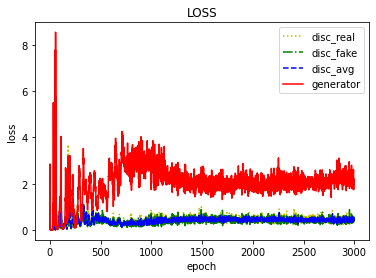

In [10]:
# 손실 그래프
import numpy as np
import matplotlib.pyplot as plt

epo = np.arange(0, epoch)

plt.figure()
plt.plot(epo, loss_disc_real,'y:',label='disc_real')
plt.plot(epo, loss_disc_fake,'g-.',label='disc_fake')
plt.plot(epo, loss_disc_avg,'b--',label='disc_avg')
plt.plot(epo, loss_gan,'r',label='generator')
plt.title('LOSS')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

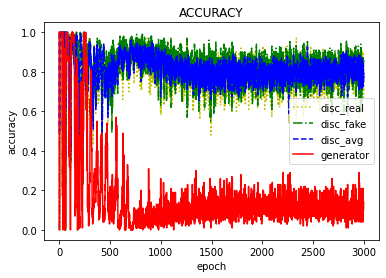

In [11]:
# 정확도 그래프
plt.figure()
plt.plot(epo, acc_disc_real,'y:',label='disc_real')
plt.plot(epo, acc_disc_fake,'g-.',label='disc_fake')
plt.plot(epo, acc_disc_avg,'b--',label='disc_avg')
plt.plot(epo, acc_gan,'r',label='generator')
plt.title('ACCURACY')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

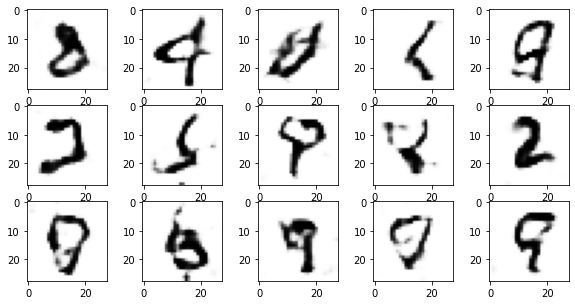

In [12]:
# epoch=3000
import matplotlib.pyplot as plt
gen_imgs = 0.5 * gen_imgs + 0.5
plt.figure(figsize=(10, 5))
for i in range(3*5):
    plt.subplot(3, 5, i+1)
    plt.imshow(gen_imgs[i].reshape((28, 28)), cmap='Greys')
plt.show()